In [4]:
import keras 
import os
import re
import numpy as np
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
%matplotlib inline
from IPython.core.display import display, HTML
from sklearn.linear_model import LogisticRegression
display(HTML("<style>.container { width:100% !important; }</style>"))

In [921]:
# Read multiple text files in a directory

data_folder = r'./Scripts'

In [922]:
# loading all the files in a directory 

all_files = os.listdir(data_folder)
print('Total Number of Files :', len(all_files))

Total Number of Files : 2827


In [923]:
# loading the training datasets 

df_train = pd.read_csv("./Train.csv")

In [924]:
# renaming the Labels to Genre just to keep the definition of lable within our context

df_train.rename(columns = {'Labels':'Genre'}, inplace = True) 

In [925]:
df_train.head()

,File_Name,Genre
0,file_2180.txt,8
1,file_693.txt,4
2,file_2469.txt,6
3,file_2542.txt,6
4,file_378.txt,16


In [926]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1978 entries, 0 to 1977
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File_Name  1978 non-null   object
 1   Genre      1978 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.0+ KB


In [927]:
df_train['Genre'] = df_train['Genre']
df_train['Genre'].unique()

array([ 8,  4,  6, 16, 15, 19,  1, 14,  0,  5,  2, 11,  7,  3, 13, 20, 21,
       12, 10, 17,  9, 18], dtype=int64)

In [928]:
# Checking the count of Genres across each docs under Movie Scripts 

df_train.Genre.value_counts()

6     405
19    261
4     243
0     203
5     141
15    134
1     116
16    109
11    104
8      79
14     75
7      27
2      25
20     18
13     15
21      9
12      4
9       3
3       2
17      2
10      2
18      1
Name: Genre, dtype: int64

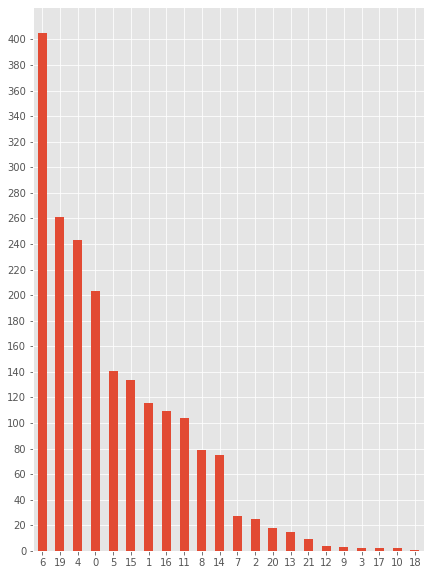

In [929]:
# Plot the counts of Genre for each sample

df_train['Genre'].value_counts().plot(kind='bar', figsize=(7,10), rot=0, yticks=range(0, 420,20))

In [930]:
# Lets load the test data for prediction when our model is trained enough

df_test = pd.read_csv('./st.csv')
df_test.head()

,File_Name,Labels
0,file_2300.txt,0
1,file_809.txt,1
2,file_1383.txt,2
3,file_983.txt,3
4,file_1713.txt,4


In [931]:
## let's read the text scripts in the train and test dataframes..

df_train['Script'] = [open(data_folder + os.sep + file, "r").read() for file in df_train['File_Name']]
df_test['Script'] = [open(data_folder + os.sep + file, "r").read() for file in df_test['File_Name']]

In [932]:
df_train.head()

,File_Name,Genre,Script
0,file_2180.txt,8,"\t\t\tCrouching Tiger, Hidden Dragon\n\n\t\t\t..."
1,file_693.txt,4,"""MUMFO..."
2,file_2469.txt,6,MAX PAYNE\n\n ...
3,file_2542.txt,6,SLUMDOG MILLIONAIRE\n\n ...
4,file_378.txt,16,<b><!--\n\n</b>if (window!= top)\n\ntop.locati...


In [933]:
# Create a function which will basically perform a cleanup of our Sripts 
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    return text

In [934]:
# Apply the cleanup function on our script in the entire dataset

df_train['Script'] = df_train['Script'].apply(preprocessor)

In [935]:
# In this step we are going to check the lenght of each script and add it as a column to our existing dataframe

df_train['Script_length'] = df_train['Script'].apply(lambda x: len(x))
df_test['Script_length'] = df_test['Script'].apply(lambda x: len(x))

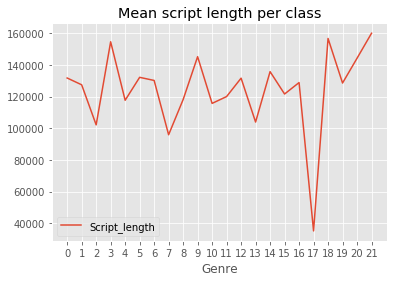

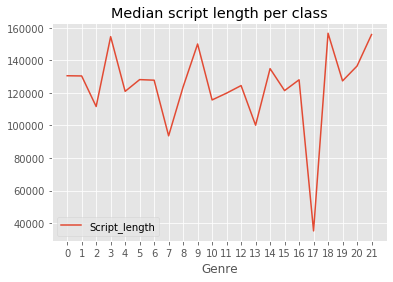

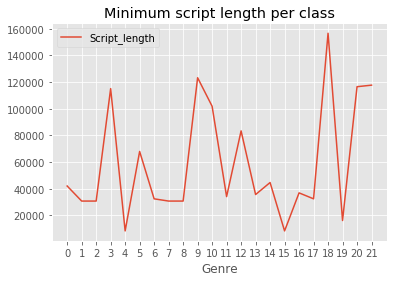

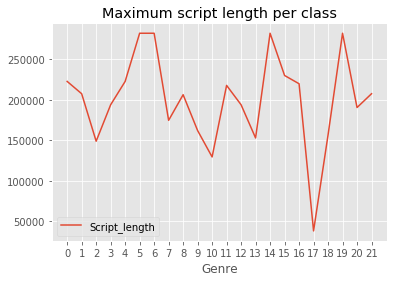

In [936]:
# Plotting is always worth pulling over for, here we are just going to plot lenght of our script against the Genre 
# different statistics

df_train.groupby('Genre').mean().plot(kind='line',rot=0, xticks=range(0,22,1), title="Mean script length per class")
df_train.groupby('Genre').median().plot(kind='line',rot=0, xticks=range(0,22,1), title="Median script length per class")
df_train.groupby('Genre').min().plot(kind='line',rot=0, xticks=range(0,22,1), title="Minimum script length per class")
df_train.groupby('Genre').max().plot(kind='line',rot=0, xticks=range(0,22,1), title="Maximum script length per class")

In [937]:
print("Samples per class (training): {}".format(np.bincount(df_train['Genre'])))
y_bin = np.bincount(df_train['Genre'])
y1 = y_bin.tolist()

Samples per class (training): [203 116  25   2 243 141 405  27  79   3   2 104   4  15  75 134 109   2
   1 261  18   9]


In [938]:
# We always try to make sure that our labels are having significant impacting during the model learning process of algorith of our choice, 
# now as we have see in the plot of Genre that Genre= 18 has only one count which definitely reduces its important for training
# in the below step we get rid of this Genre = 18 and reset the index , to make sure no impact in the dataset

temp = df_train.drop(df_train[df_train['Genre'] ==18].index[0], axis=0)

In [939]:
# Let's split our data to training and validation set

X_train, X_test, y_train, y_test = train_test_split(temp[['Script']].values, temp.Genre.values, 
                                                    test_size=0.3, 
                                                    stratify= temp.Genre.values, 
                                                    random_state=42, shuffle=True)

In [940]:
len(set(y_test))

21

In [941]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1383, 1)
(594, 1)
(1383,)
(594,)


In [943]:
# # Now as we are readling with a text data , we have to create our own vocabulury and the best way to deal with it is to use the TFIDF , 
# which retrieves the most signifcant words in our document= 'Script' and then convert these words into a vector which will be later fed to our 
# machine learning mode . Let's begin by using the below set of parameters!

tfv = TfidfVectorizer(min_df=3,  max_features=100, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

In [944]:
# Fitting TF-IDF to both training and test sets (semi-supervised learning)
temp = (list(X_train) + list(X_test))
temp = np.asarray(temp).reshape(-1)
tfv.fit(temp)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=100,
                min_df=3, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=1, stop_words='english', strip_accents='unicode',
                sublinear_tf=1, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=1, vocabulary=None)

In [945]:
# Lets transform the words into vectors for our machine learning algorithm to understand our Script text data 

x_train_tfv = tfv.transform(np.asarray(X_train).reshape(-1))
x_test_tfv = tfv.transform(np.asarray(X_test).reshape(-1))

In [946]:
# As it is a classification problem, lets use our well know logistic regression on our x and y data 

log = LogisticRegression(C=1.0)
log.fit(x_train_tfv, y_train)

C:\Users\akudnaver\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [947]:
# We basically want to predict the probablity of the multiclass across our individual samples("Script text")
prediction = log.predict_proba(x_test_tfv)

In [948]:
prediction.shape

(594, 21)

In [949]:
# In this step we will calculate the loss incurred by our logistic regression alogrithm based on our parameters used for the model 
print("logistic loss score in %: {}".format(log_loss(y_test, prediction)))

logistic loss score in %: 2.32353131759152


In [950]:
# It appears our model is able to predict 97% of the prediction correctly, now we will use our model on the entire data for predicting the Genre !!
x_train = df_train.Script.values
y_train = df_train.Genre.values
x_test = df_test.Script.values

In [951]:
# lets quickly verify the shape of our data 

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(1978,)
(1978,)
(849,)


In [952]:
# # Now as we are readling with a text data , we have to create our own vocabulury and the best way to deal with it is to use the TFIDF , 
# which retrieves the most signifcant words in our document= 'Script' and then convert these words into a vector which will be later fed to our 
# machine learning mode . Let's begin by using the below set of parameters!

tfv_c = TfidfVectorizer(min_df=3,  max_features=100, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

In [953]:
tfv_c.fit(np.asarray(x_train).reshape(-1))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=100,
                min_df=3, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=1, stop_words='english', strip_accents='unicode',
                sublinear_tf=1, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=1, vocabulary=None)

In [954]:
# Lets transform the words into vectors for our machine learning algorithm to understand our Script text data 

x_train_tfv = tfv_c.transform(x_train)
x_test_tfv = tfv_c.transform(x_test)

In [955]:
print(x_train_tfv.shape)
print(y_train.shape)
print(x_test_tfv.shape)

(1978, 100)
(1978,)
(849, 100)


In [956]:
# lets fit the logistic regression on the entire training data
log2 = LogisticRegression(C=1.0,solver='lbfgs',max_iter=100)
log2.fit(x_train_tfv, y_train)

C:\Users\akudnaver\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [957]:
# We can now use our model to predict the test data set, which is our 'Script', which shall return the probability 
# of different Genres
predict_test = log2.predict_log_proba(x_test_tfv)

In [958]:
# Converting the pridiction to a dataframe , we are passing the absolute function to remove the 
# negative values

prediction_df = abs(pd.DataFrame(predict_test))

In [959]:
prediction_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,2.680064,3.212109,4.437219,6.997489,1.765742,2.710183,1.347320,4.535755,3.554214,6.554465,...,6.336016,5.022180,3.330304,2.597778,3.241087,6.922863,7.641846,2.067943,4.746328,5.618215
1,2.882385,3.205957,4.429695,7.027598,1.665394,2.686316,1.278721,4.548360,3.483567,6.631474,...,6.397679,5.031493,3.344240,2.317695,3.311777,6.985037,7.691957,2.405437,4.850136,5.670201
2,1.979675,1.987477,4.158032,6.776376,2.661071,3.484322,1.766610,4.078750,2.869276,6.398794,...,6.051961,4.666008,3.443324,2.790818,2.325524,6.833819,7.513571,2.430912,4.498830,5.168879
3,2.604371,3.228897,4.543527,6.952094,1.799526,2.625197,1.520577,4.529213,3.231675,6.668924,...,6.231523,5.197782,3.443884,2.197572,2.986038,6.939432,7.688580,2.217421,4.968002,5.520712
4,1.790809,2.324321,4.273895,6.859142,2.554055,2.656143,1.820832,4.433285,3.211163,6.476691,...,6.251962,4.780348,3.135941,2.826434,2.681021,6.824307,7.482550,2.187523,4.591923,5.430912


In [960]:
prediction_df['File_Name'] = df_test['File_Name']

In [961]:
# lets insert the File_Name column along with the predicted labels corresponding to the Samples Scripts.
col_order = [i for i in range(0,22)]
col_order.insert(0, 'File_Name')
prediction_df = prediction_df[col_order]

In [962]:
prediction_df.head()

,File_Name,0,1,2,3,4,5,6,7,8,...,12,13,14,15,16,17,18,19,20,21
0,file_2300.txt,2.680064,3.212109,4.437219,6.997489,1.765742,2.710183,1.347320,4.535755,3.554214,...,6.336016,5.022180,3.330304,2.597778,3.241087,6.922863,7.641846,2.067943,4.746328,5.618215
1,file_809.txt,2.882385,3.205957,4.429695,7.027598,1.665394,2.686316,1.278721,4.548360,3.483567,...,6.397679,5.031493,3.344240,2.317695,3.311777,6.985037,7.691957,2.405437,4.850136,5.670201
2,file_1383.txt,1.979675,1.987477,4.158032,6.776376,2.661071,3.484322,1.766610,4.078750,2.869276,...,6.051961,4.666008,3.443324,2.790818,2.325524,6.833819,7.513571,2.430912,4.498830,5.168879
3,file_983.txt,2.604371,3.228897,4.543527,6.952094,1.799526,2.625197,1.520577,4.529213,3.231675,...,6.231523,5.197782,3.443884,2.197572,2.986038,6.939432,7.688580,2.217421,4.968002,5.520712
4,file_1713.txt,1.790809,2.324321,4.273895,6.859142,2.554055,2.656143,1.820832,4.433285,3.211163,...,6.251962,4.780348,3.135941,2.826434,2.681021,6.824307,7.482550,2.187523,4.591923,5.430912


In [964]:
# Saving the prediction to an excel file

prediction_df.to_excel('./Movie_Scripts_Predicted_Proability.xlsx', index=None)